# Test using demo profiles
How do these results compare against Hertzog et al. 2012? They use a highly idealized setup with constant $N$, assuming incompressibility and only trigger based on zonal winds. They utilize a simple constant source spectrum. Does this compare against AD99py?

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from ad99py import AlexanderDunkerton1999

In [2]:
H = 8000 # Scale height
NVal = 0.02 # constant N 
UVar = 7

z = np.arange(9000,55000,1000)

rho0 = 1 # kg/m^3
rho = rho0*np.exp(-z/H)
N = np.ones_like(z)*NVal

In [3]:
u = np.random.normal(size=z.shape)*UVar
u[0] = 0

In [4]:
ad99 = AlexanderDunkerton1999(dc=0.4,source_level_height=9000,use_intrinsic_c='always',Fs0=1)


/home/groups/aditis2/robcking/ad99py/src/ad99py/ad99.py:65: UserWarning: `source` is not set, using default Gaussian source spectrum, with `cw=35` and `Bm=0.4`.
  warn(f"`source` is not set, using default Gaussian source spectrum, with `cw={cw}` and `Bm={Bm}`.")


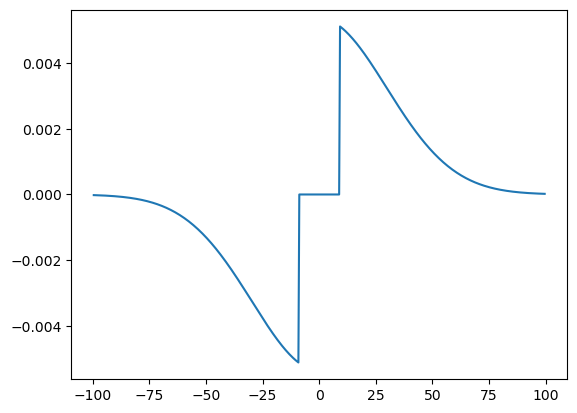

In [5]:
plt.plot(ad99.c0,ad99.filtered_source_spectrum(u,N,z,rho))

In [6]:
from ad99py.ad99dask import AlexanderDunkerton1999Dask
ad99vc = AlexanderDunkerton1999Dask(dc=0.2,source_level_height=9000,use_intrinsic_c='always',Fs0=1)

In [7]:
uw_neg,uw_ptv = ad99.momentum_flux_neg_ptv(u,N,z,rho)

In [8]:
N_realization = int(5e5)
Fs = np.zeros((N_realization,*z.shape))
us = np.random.normal(size=(N_realization,*z.shape))*UVar
us[:,0] = 0.0
Ns = np.ones_like(us)*NVal
zs = np.broadcast_to(z,us.shape)
rhos = np.broadcast_to(rho,us.shape)

In [9]:
import dask.array as da
us = da.from_array(us,chunks=(1000,-1))
Ns = da.from_array(Ns,chunks=us.chunks)
zs = da.from_array(zs,chunks=us.chunks)
rhos = da.from_array(rhos,chunks=us.chunks)

In [10]:
neg,ptv = ad99vc.momentum_flux_neg_ptv(us,Ns,zs,rhos)

In [11]:
ptv_np = ptv.compute()

In [12]:
Fs0 = ptv_np[:,0].max()
ptv_np = ptv_np / Fs0 

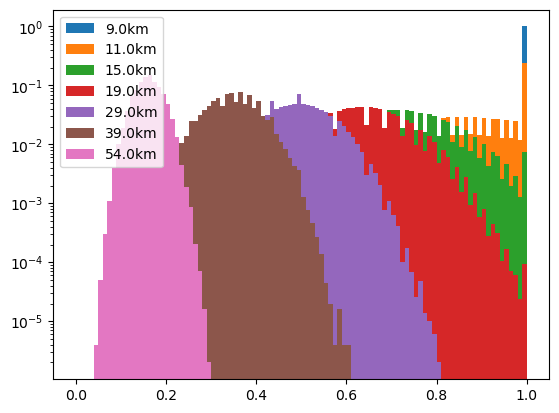

In [13]:
izs = [0,2,6,10,20,30,45]
dF = 0.01
bins = np.arange(0,1+dF,dF)
centers = (bins[:-1] + bins[1:])*0.5
for i,iz in enumerate(izs):
    counts,_ = np.histogram(ptv_np[:,iz],bins=bins,density=True)
    counts = counts * dF 
    plt.bar(centers,counts,width=dF,label=f'{z[iz]/1000}km')
plt.legend()
plt.yscale('log')

/tmp/ipykernel_22815/2895993094.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


(0.0, 10.0)

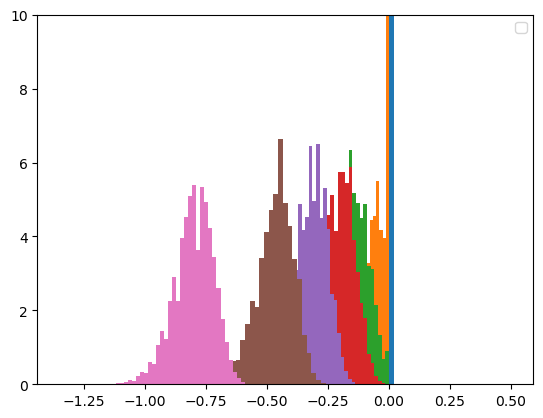

In [22]:
izs = [0,2,6,10,20,30,45]
for i,iz in enumerate(izs):
    plt.hist(np.log10(ptv_np[:,iz]),density=True,bins=50)
plt.legend()
plt.ylim(0,10)


## Constant sources

In [15]:
from ad99py.sources import make_source_spectrum

def constant_hertzog_source(c,c0,cw,Bm):
    return np.where((5< c) & (c < 60), Bm, 0)

source = make_source_spectrum(constant_hertzog_source,0,1)

ad99source = AlexanderDunkerton1999Dask(source=source,dc=0.2,source_level_height=9000,use_intrinsic_c='always',Fs0=1,Bm=1)

In [16]:


_, constantptv = ad99source.momentum_flux_neg_ptv(us,Ns,zs,rhos)

constantptv = constantptv.compute()

In [17]:
Fs0 = constantptv [:,0].max()
constantptv  = constantptv / Fs0 

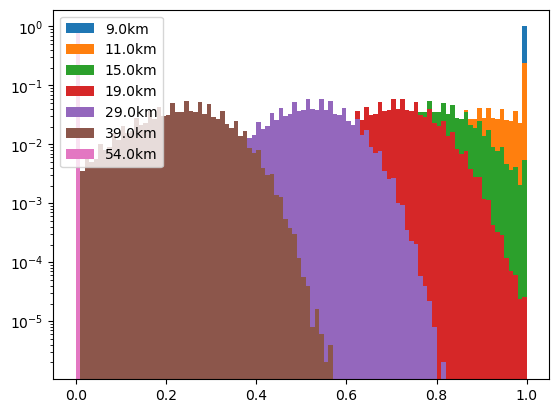

In [18]:
izs = [0,2,6,10,20,30,45]
dF = 0.01
bins = np.arange(0,1+dF,dF)
centers = (bins[:-1] + bins[1:])*0.5
for i,iz in enumerate(izs):
    counts,_ = np.histogram(constantptv[:,iz],bins=bins,density=True)
    counts = counts * dF 
    plt.bar(centers,counts,width=dF,label=f'{z[iz]/1000}km')
plt.legend()
plt.yscale('log')

/tmp/ipykernel_22815/3783114351.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(constantptv[:,iz]),density=True,bins=np.linspace(-1,0,100))
/tmp/ipykernel_22815/3783114351.py:3: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(constantptv[:,iz]),density=True,bins=np.linspace(-1,0,100))
/home/groups/aditis2/robcking/condaenvs/ad99py/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_22815/3783114351.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


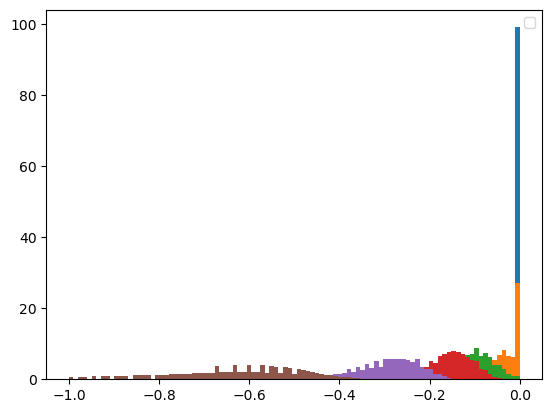

In [19]:
izs = [0,2,6,10,20,30,45]
for i,iz in enumerate(izs):
    plt.hist(np.log10(constantptv[:,iz]),density=True,bins=np.linspace(-1,0,100))
plt.legend()



In [20]:
import xarray as xr 
ds = xr.open_dataset('../../data/atmos_4xdaily_flag0.nc',chunks={'time':1})[['ucomp','height']].transpose('time','lat','lon','pfull')
u = ds.ucomp.data.reshape(-1,40)
z = ds.height.data.reshape(-1,40)

In [21]:
u

dask.array<reshape, shape=(58982400, 40), dtype=float32, chunksize=(8192, 40), chunktype=numpy.ndarray>